<img src="https://storage.googleapis.com/kaggle-datasets-images/1569305/2583418/b232f5dc57e9b774fc6eafa6635f0782/dataset-cover.png?t=2021-09-03-12-12-22" width="400" align="center"></a>

<h1 align="center"><font size="5">Project: Review analysis - Review analysis of Amazon Kindle Book Review</font></h1>

<!-- Please read [Gemstone price prediction information](https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction) carefully before you do this project! -->

Dataset: all_kindle_review.csv

#### Data dictionary:

* asin - ID of the product, like B000FA64PK
* helpful - helpfulness rating of the review - example: 2/3.
* overall - rating of the product.
* reviewText - text of the review (heading).
* reviewTime - time of the review (raw).
* reviewerID - ID of the reviewer, like A3SPTOKDG7WBLN
* reviewerName - name of the reviewer.
* summary - summary of the review (description).
* unixReviewTime - unix timestamp.

### Requirements:

- Data exploration
- Data visualization
- Pre-processing: Feature selection/extraction
- Logistic Regression
    - Model Evaluation using Test set
    - Report

### Import library

In [82]:
# !pip install langdetect 
# !pip install wordcloud
# !pip install textblob
# !pip install imbalanced-learn

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from textblob import Word
from sklearn.pipeline import Pipeline
from sklearn import metrics
from langdetect import detect

In [84]:
import warnings
warnings.filterwarnings('ignore')

### Read and overview dataset

In [85]:
data = pd.read_csv('input_data/all_kindle_review.csv', index_col=0)
data.head()

,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      12000 non-null  int64 
 1   asin            12000 non-null  object
 2   helpful         12000 non-null  object
 3   rating          12000 non-null  int64 
 4   reviewText      12000 non-null  object
 5   reviewTime      12000 non-null  object
 6   reviewerID      12000 non-null  object
 7   reviewerName    11962 non-null  object
 8   summary         11998 non-null  object
 9   unixReviewTime  12000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 1.0+ MB


### Check imbalance datasets

In [87]:
data.rating.value_counts()

rating
5    3000
4    3000
3    2000
2    2000
1    2000
Name: count, dtype: int64

Star >= 3 would be positive, others must be negative

In [88]:
data['sentiment'] = data['rating'].apply(lambda x: 1 if x>=3 else 0) 

In [89]:
data.head()

,Unnamed: 0,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,sentiment
0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600,1
1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400,1
2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400,1
3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400,1
4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000,1


In [90]:
data.sentiment.value_counts()

sentiment
1    8000
0    4000
Name: count, dtype: int64

Seem that we have imbalance dataset problem, need to handle in later step

### Get 2 columns reviewText and sentiment for sentiment analysis

In [91]:
data = data[['reviewText', 'sentiment']]

### Pre-processing data

#### Convert to lower case

In [92]:
data.reviewText = data['reviewText'].apply(lambda x: x.lower())
data.reviewText.head()

0    jace rankin may be short, but he's nothing to ...
1    great short read.  i didn't want to put it dow...
2    i'll start by saying this is the first of four...
3    aggie is angela lansbury who carries pocketboo...
4    i did not expect this type of book to be in li...
Name: reviewText, dtype: object

#### Check duplicate and remove

In [93]:
data.reviewText.duplicated().sum()

np.int64(0)

No duplicated data

#### Check missing values

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewText  12000 non-null  object
 1   sentiment   12000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.2+ KB


* No missing values

### Check Language of review

In [95]:
from tqdm import tqdm
tqdm.pandas()
df_check_lang = data['reviewText'].progress_apply(detect)

100%|██████████| 12000/12000 [00:29<00:00, 413.78it/s]


In [96]:
df_check_lang.value_counts()

reviewText
en    11991
af        4
cs        1
sl        1
no        1
it        1
es        1
Name: count, dtype: int64

* Most of language is english, need to remove others

In [97]:
data = data[df_check_lang=='en']

#### Removing Punctuation

In [98]:
import string
lst_stop_words = set(stopwords.words('english'))
data.reviewText = data['reviewText'].apply(lambda x: ''.join(char for char in x if char not in string.punctuation))
data.reviewText.head()

0    jace rankin may be short but hes nothing to me...
1    great short read  i didnt want to put it down ...
2    ill start by saying this is the first of four ...
3    aggie is angela lansbury who carries pocketboo...
4    i did not expect this type of book to be in li...
Name: reviewText, dtype: object

#### Replace Numbers with a Space

In [99]:
data.reviewText = data.reviewText.str.replace('\d+', ' ', regex=True)
data.reviewText = data.reviewText.str.replace('\s+', ' ', regex=True)
data.reviewText.head()

0    jace rankin may be short but hes nothing to me...
1    great short read i didnt want to put it down s...
2    ill start by saying this is the first of four ...
3    aggie is angela lansbury who carries pocketboo...
4    i did not expect this type of book to be in li...
Name: reviewText, dtype: object

#### Remove stopword

In [100]:
lst_stop_words = set(stopwords.words('english'))
data.reviewText = data['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if word not in lst_stop_words))

In [101]:
data.reviewText.head()

0    jace rankin may short hes nothing mess man hau...
1    great short read didnt want put read one sitti...
2    ill start saying first four books wasnt expect...
3    aggie angela lansbury carries pocketbooks inst...
4    expect type book library pleased find price right
Name: reviewText, dtype: object

#### Lemmatization

In [102]:
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

data.reviewText = data.reviewText.apply(lambda x: ' '.join(lemma.lemmatize(word) for word in x.split()))

data.reviewText.head()

0    jace rankin may short he nothing mess man haul...
1    great short read didnt want put read one sitti...
2    ill start saying first four book wasnt expecti...
3    aggie angela lansbury carry pocketbook instead...
4    expect type book library pleased find price right
Name: reviewText, dtype: object

### Visualize

#### Visualize wordcloud for positive comments

In [103]:
positive_cmt = data[data.sentiment == 1].reviewText

In [104]:
positive_cmt = ' '.join(positive_cmt)

In [105]:
wc = WordCloud().generate(positive_cmt)
wc

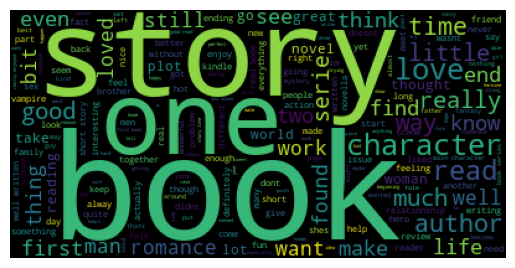

In [106]:
plt.imshow(wc)
plt.axis('off')
plt.show()

#### Visualize wordcloud for negative comments

In [107]:
negative_cmt = data[data.sentiment == 0].reviewText
negative_cmt = ' '.join(negative_cmt)
wc = WordCloud().generate(negative_cmt)
wc

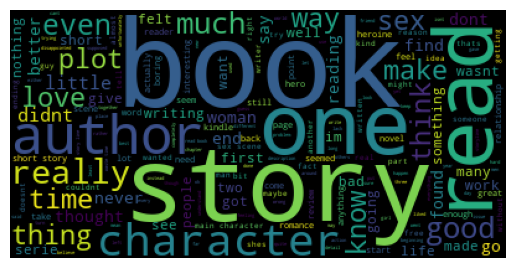

In [108]:
plt.imshow(wc)
plt.axis('off')
plt.show()

### Build Model

#### Split into input/output

In [207]:
X = data['reviewText']
y = data['sentiment']

In [208]:
data.reviewText.tail(5)

11995    valentine cupid vampire jena ian another vampi...
11996    read seven book series apocalypticadventure on...
11997    book really wasnt cuppa situation man capturin...
11998    tried use charge kindle didnt even register ch...
11999    taking instruction look often hidden world sex...
Name: reviewText, dtype: object

In [209]:
data.sentiment.head(5)

0    1
1    1
2    1
3    1
4    1
Name: sentiment, dtype: int64

#### Split into train/test 

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [283]:
X_train.head()

884     couldnt finish book wandered never seemed gel ...
4175    enjoyed book demon world real kept attention b...
8713    en mcnamaras grid solid mixture survival story...
4116    illustration describe good job jules verne hus...
9873    time im asked review say pretty much thing eit...
Name: reviewText, dtype: object

#### Handle imbalance dataset 

##### Note: I think this is not imbalance because the negative cmt possess 30% records, imbalance in realife I think like 9:1 or 9.5 : 0.5 like card fraud detection datasets which i used to predict on kaggle

In [284]:
y.value_counts()

sentiment
1    7994
0    3997
Name: count, dtype: int64

##### oversampling

In [285]:
# from imblearn.over_sampling import SMOTE

##### undersampling

#### Init pipeline for transform and training

In [286]:
#tf-idf with max_feature=900
#model logistic regression

In [287]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [288]:
X_train.shape

(8993,)

In [289]:
y_train.shape

(8993,)

In [290]:
_chain = [
    ('vectorizing', TfidfVectorizer(max_features=900, stop_words='english')),
    ('modeling', LogisticRegression())
]

_pipeline = Pipeline(_chain)
_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(max_features=900, stop_words='english')),
                ('modeling', LogisticRegression())])

In [291]:
from sklearn.metrics import accuracy_score
y_hat_test = _pipeline.predict(X_test)
accuracy_score(y_test, y_hat_test)

0.8262174783188793

In [292]:
y_hat_train = _pipeline.predict(X_train)
accuracy_score(y_train, y_hat_train)

0.8524407872789947

### Evaluate result

In [293]:
# Xem kết quả thống kê
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, y_hat_test)


array([[ 650,  349],
       [ 172, 1827]])

In [294]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       999
           1       0.84      0.91      0.88      1999

    accuracy                           0.83      2998
   macro avg       0.82      0.78      0.79      2998
weighted avg       0.82      0.83      0.82      2998



In [295]:
from sklearn.metrics import roc_auc_score, roc_curve

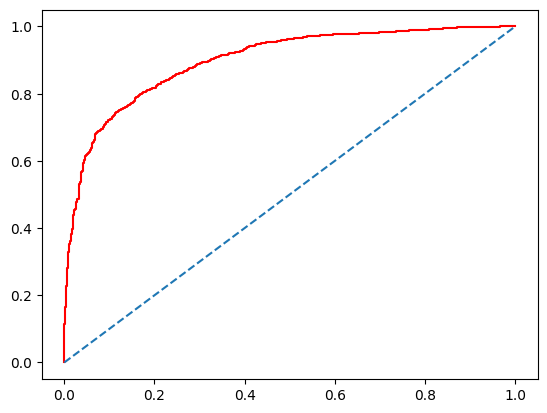

In [296]:
# calculate roc curve
y_hat_test_proba = _pipeline.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_hat_test_proba[:,1])
plt.plot(fpr, tpr, c='r')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()


In [297]:
# calculate AUC
auc = roc_auc_score(y_test, y_hat_test_proba[:,1])
print(f'AUC: {auc}')


AUC: 0.898230396479521


### Evaluate result for adjusting threshold

In [298]:
yhat = (y_hat_test_proba[:,1] >= 0.65).astype(int)

In [299]:
confusion_matrix(y_test, y_hat)


array([[ 268,  731],
       [ 505, 1494]])

In [300]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       999
           1       0.89      0.82      0.85      1999

    accuracy                           0.81      2998
   macro avg       0.79      0.81      0.80      2998
weighted avg       0.82      0.81      0.82      2998



In [301]:
# We can use loop and set some states to find the best ones

#### Save model

In [304]:
import pickle
import os

os.makedirs('model_checkpoints', exist_ok=True)
pickle.dump(_pipeline, open('model_checkpoints/model.pkl', 'wb'))